In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
from linearmodels.iv import IV2SLS

%matplotlib inline

pd.set_option("display.max_columns", 10)
style.use("fivethirtyeight")

# Source Causal Inference for the Braves and True
https://matheusfacure.github.io/python-causality-handbook/landing-page.html

## Key Ideas
If we can't measure directly the confounders, the idea is to find another variable (Instrument Variable) that causes the treatment and it is only correlated with the outcome through the treatment. 

An instrument is a variable that is correlated with the treatment (has a first stage), but only affects the outcome through the treatment (exclusion restriction). 

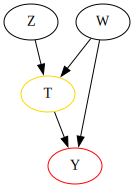

In [18]:
g = gr.Digraph()
g.node("Z", color="black"),
g.node("W", color="black"),
g.node("T", color="gold"),
g.node("Y", color="red"),
g.edge("Z", "T")
g.edge("W", "T")
g.edge("W", "Y")
g.edge("T", "Y")
g

$
Y_i = \beta_0 + \kappa \ T_i + \pmb{\beta}W_i + u_i
$

However, we don't have data on $W$, so all we can run is

$
Y_i = \beta_0 + \kappa\ T_i + v_i
$

$
v_i = \pmb{\beta}W_i + u_i
$

Since $W$ is a confounder, $\mathrm{Cov}(T, v) \neq 0$.
Since the instrument Z is only correlated with the outcome through T, this implies that $\mathrm{Cov}(Z,v) = 0$.

$
\mathrm{Cov}(Z,Y) = \mathrm{Cov}(Z,\beta_0 + \kappa\ T_i + v_i) = \kappa \mathrm{Cov}(Z,T) + \mathrm{Cov}(Z, v) = \kappa \mathrm{Cov}(Z,T)
$

Dividing each side by $V(Z_i)$ and rearranging the terms, we get

$
\kappa = \dfrac{\mathrm{Cov}(Y_i, Z_i)/V(Z_i)}{\mathrm{Cov}(T_i, Z_i)/V(Z_i)} = \dfrac{\text{Reduced Form}}{\text{1st Stage}} 
$

Notice that both the numerator and the denominator are regression coefficients (covariances divided by variances). The numerator is the result from the regression of Y on Z. In other words, it's the "impact" of Z on Y. This numerator is *the reduced form coefficient*.

The denominator is also a regression coefficient. This time, it is the regression of T on Z, it is called the *1st Stage coefficient*. 


$
\kappa = \dfrac{\frac{\partial y}{\partial z}}{\frac{\partial T}{\partial z}} = \dfrac{\partial y}{\partial z} * \dfrac{\partial z}{\partial T} =  \dfrac{\partial y}{\partial T}
$

We can also see this in a simplified case where the instrument is a dummy variable. In this case, the IV estimator gets further simplified by the ratio between 2 differences in means.

$
\kappa = \dfrac{E[Y|Z=1]-E[Y|Z=0]}{E[T|Z=1]-E[T|Z=0]}
$

This ratio is sometimes referred to as the **Wald Estimator**.


In [2]:
data = pd.read_csv("./data/ak91.csv")
data.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth
0,5.790019,12.0,30.0,1.0,45.0
1,5.952494,11.0,30.0,1.0,45.0
2,5.315949,12.0,30.0,1.0,45.0
3,5.595926,12.0,30.0,1.0,45.0
4,6.068915,12.0,30.0,1.0,37.0


Before using quarter of birth (QOB) as instrumental variable (IV) we need to check the conditions:
1. $\mathrm{Cov}(Z, T) \neq 0$
2. $Y \perp Z | T $

In [3]:
factor_data = data.assign(**{f"q{int(q)}": (data["quarter_of_birth"] == q).astype(int) for q in data["quarter_of_birth"].unique()})
factor_data.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth,q1,q2,q3,q4
0,5.790019,12.0,30.0,1.0,45.0,1,0,0,0
1,5.952494,11.0,30.0,1.0,45.0,1,0,0,0
2,5.315949,12.0,30.0,1.0,45.0,1,0,0,0
3,5.595926,12.0,30.0,1.0,45.0,1,0,0,0
4,6.068915,12.0,30.0,1.0,37.0,1,0,0,0


For simplicity, let's consider q4 the instrument (Z) and years_of_schooling the treatment (T).
We will run a regression of years_of_schooling on q4. We also need to control for years  of birth and state of birth.

In [4]:
first_stage = smf.ols("years_of_schooling ~ C(year_of_birth) + C(state_of_birth) + q4", data = factor_data).fit()

In [5]:
print("q4 parameter estimate:, ", first_stage.params["q4"])
print("q4 p-value:, ", first_stage.pvalues["q4"])

q4 parameter estimate:,  0.10085809272786139
q4 p-value:,  5.464829416631669e-15


The P-value is close to 0 confirming that those born in the last quarter have, on average 0.1 more years of education.

In [6]:
group_data = (data
              .groupby(["year_of_birth", "quarter_of_birth"])
              [["log_wage", "years_of_schooling"]]
              .mean()
              .reset_index()
              .assign(time_of_birth = lambda d: d["year_of_birth"] + (d["quarter_of_birth"])/4))

In [7]:
group_data.head()

,year_of_birth,quarter_of_birth,log_wage,years_of_schooling,time_of_birth
0,30.0,1.0,5.889133,12.280405,30.25
1,30.0,2.0,5.898007,12.428418,30.50
2,30.0,3.0,5.909365,12.491860,30.75
3,30.0,4.0,5.914354,12.624675,31.00
4,31.0,1.0,5.902136,12.540434,31.25


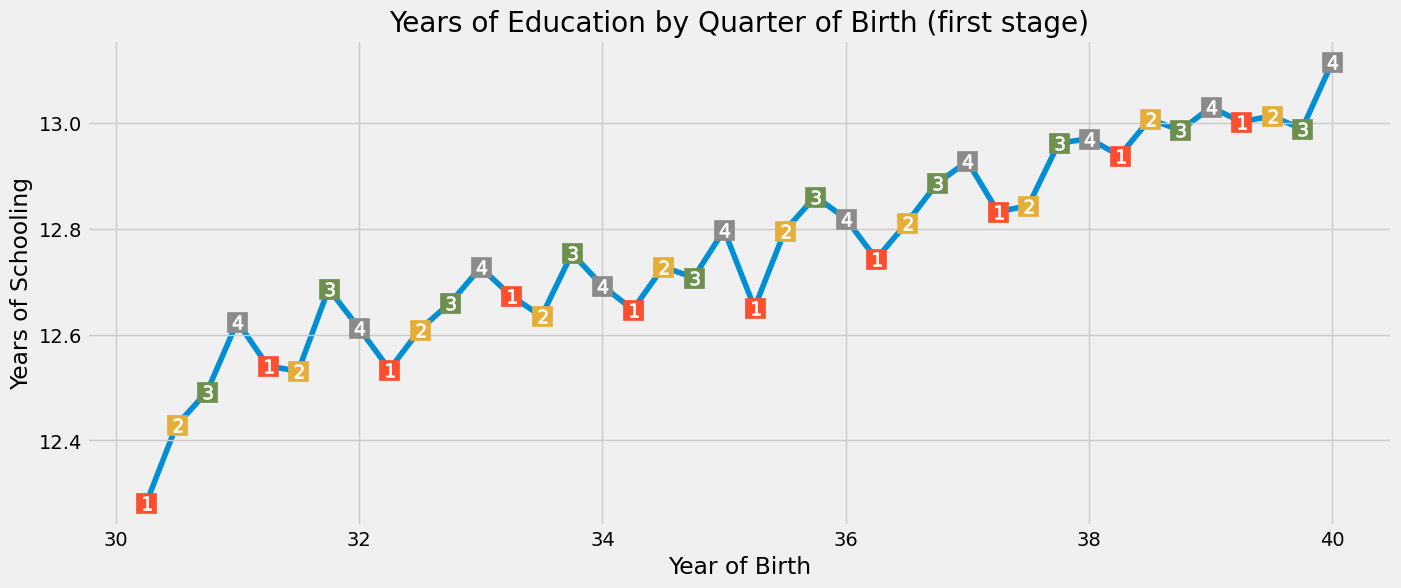

In [8]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["years_of_schooling"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["years_of_schooling"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Years of Education by Quarter of Birth (first stage)")
plt.xlabel("Year of Birth")
plt.ylabel("Years of Schooling");

Visually we can see that those born in the first quarter of the year have almost always less education than those born in the last quarter

We can't verify the second IV condition. We can only argue in favor of it. We can express our belief that quarter of birth does not influence potential earnings.

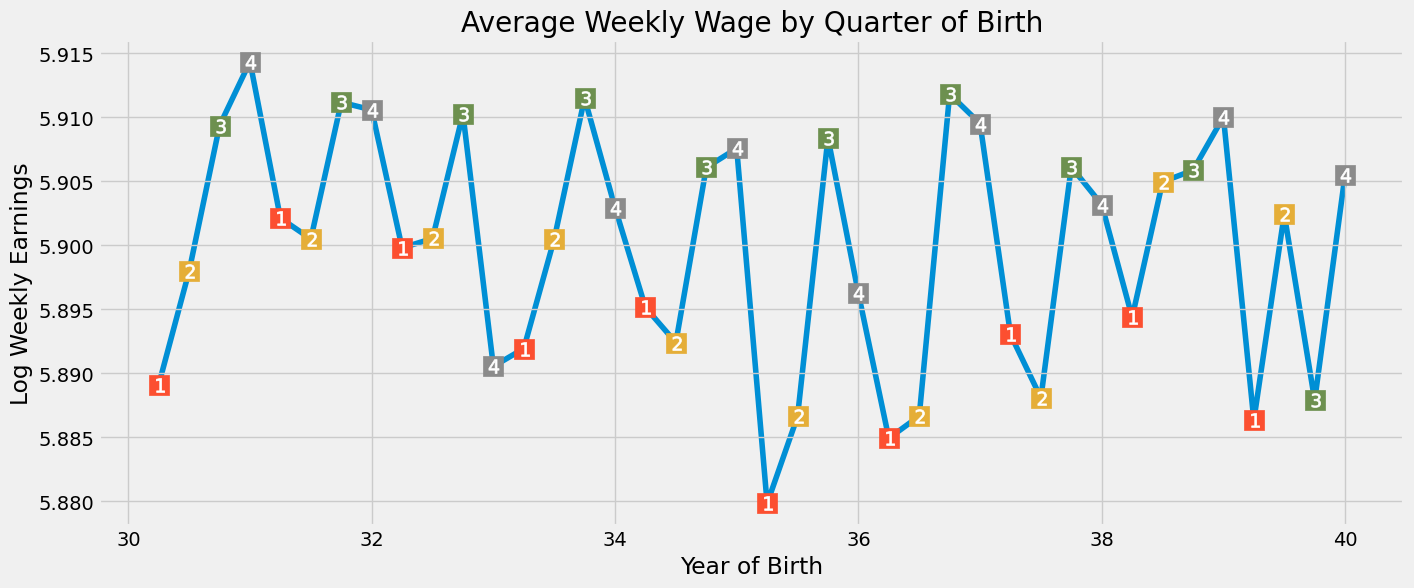

In [9]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["log_wage"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["log_wage"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")
    
plt.title("Average Weekly Wage by Quarter of Birth")
plt.xlabel("Year of Birth")
plt.ylabel("Log Weekly Earnings");    


We can see that those born later have slightly higher income than those born earlier in the year

In [10]:
reduced_form = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", reduced_form.params["q4"])
print("q4 p-value:, ", reduced_form.pvalues["q4"])

q4 parameter estimate:,  0.008603484260136768
q4 p-value:,  0.0014949127183721367


Significant result: those born later in the year have on average 0.8% higher wages

This gives us the unbiased IV estimate of the average effect

In [11]:
reduced_form.params["q4"] / first_stage.params["q4"]

0.08530286492082466

We should expect each additional year of school to increase wages by 8%

In 2 stages least squares (2SLS) any additional control variable added to the second stage should be added to the first stage.

In [12]:
iv_by_hand = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + years_of_schooling_fitted",
                     data=factor_data.assign(years_of_schooling_fitted=first_stage.fittedvalues)).fit()

iv_by_hand.params["years_of_schooling_fitted"]

0.08530286492080791

Using IV2SLS library

In [43]:
def parse(model, exog="years_of_schooling"):
    param = model.params[exog]
    se = model.std_errors[exog]
    p_val = model.pvalues[exog]
    print(f"Parameter: {param}")
    print(f"SE: {se}")
    print(f"95 CI: {(-1.96*se,1.96*se) + param}")
    print(f"P-value: {p_val}")
    
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q4]'
iv2sls = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv2sls)

Parameter: 0.08530286490713479
SE: 0.025540812816361964
95 CI: [0.03524287 0.13536286]
P-value: 0.0008381914687034531


# Adding more instruments

In [46]:
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q1+q2+q3]'
iv_many_zs = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv_many_zs)

Parameter: 0.10769370487469132
SE: 0.01955714900989459
95 CI: [0.06936169 0.14602572]
P-value: 3.657974700921329e-08


In [47]:
formula = "log_wage ~ years_of_schooling + C(state_of_birth) + C(year_of_birth) + C(quarter_of_birth)"
ols = IV2SLS.from_formula(formula, data=data).fit()
parse(ols)

Parameter: 0.06732572817658422
SE: 0.0003883998439048649
95 CI: [0.06656446 0.06808699]
P-value: 0.0
